In [274]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, fbeta_score

In [275]:
df = pd.read_csv('blood_transfusion.csv', na_values=['NA', 'null', '', 'NULL']) 

df = df.drop(columns=['total_blood_donated'])

# Seeing in the dataset if there are records that have donated more than once per month
loc_df_total_minus_last = (df['months_since_first_donation'] - df['months_since_last_donation']) + 1
df = df[df['total_number_of_donations'] <= loc_df_total_minus_last]

df_with_freq = df.copy()
df_with_freq['Average_frequency_donations'] = df['months_since_first_donation'] / df['total_number_of_donations']

df.describe()

loc_df_class_0 = df.loc[df['class'] == 0]
loc_df_class_1 = df.loc[df['class'] == 1]
loc_df_class_0_with_freq = df_with_freq.loc[df['class'] == 0]
loc_df_class_1_with_freq = df_with_freq.loc[df['class'] == 1]

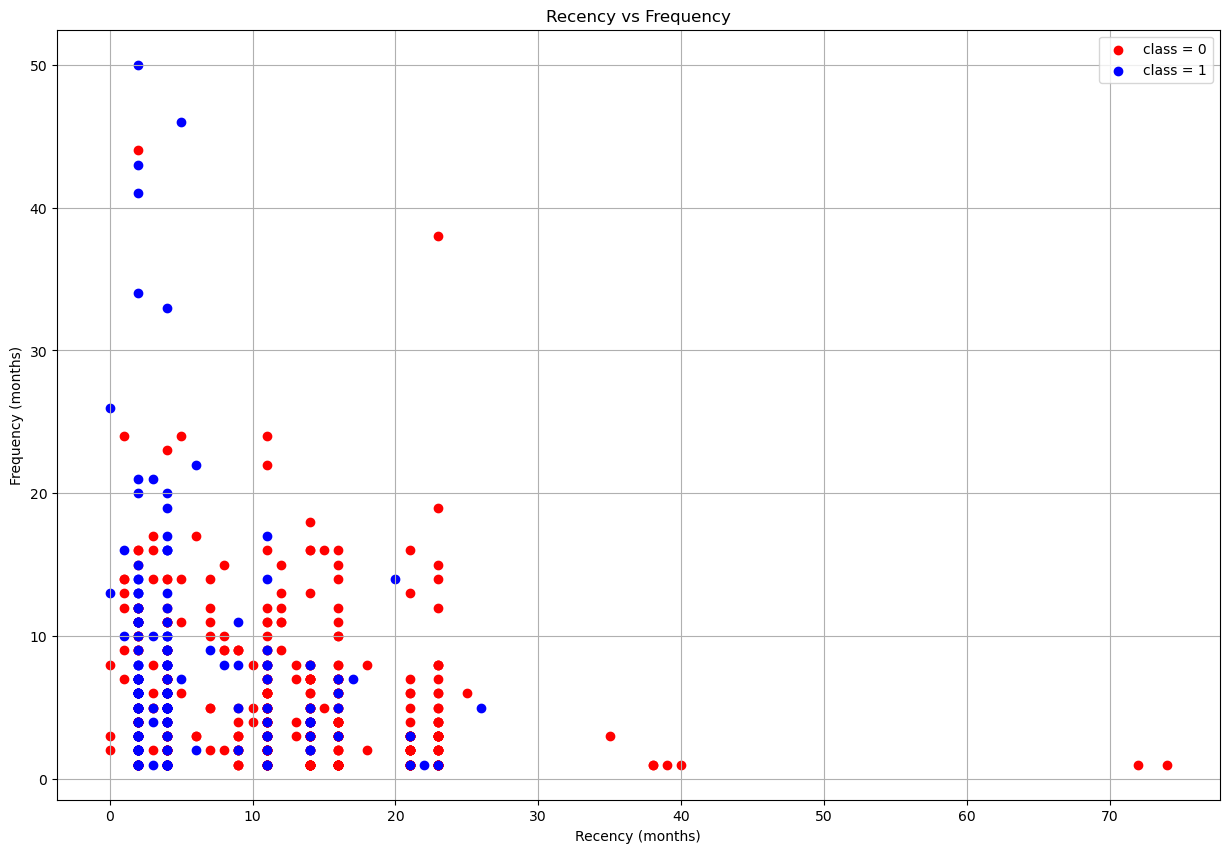

In [276]:
plt.figure(figsize=(15, 10))
plt.scatter(loc_df_class_0['months_since_last_donation'], loc_df_class_0['total_number_of_donations'], color='red', label='class = 0')
plt.scatter(loc_df_class_1['months_since_last_donation'], loc_df_class_1['total_number_of_donations'], color='blue', label='class = 1')
plt.xlabel('Recency (months)')
plt.ylabel('Frequency (months)')
plt.title('Recency vs Frequency')
plt.legend()
plt.grid()
plt.show()


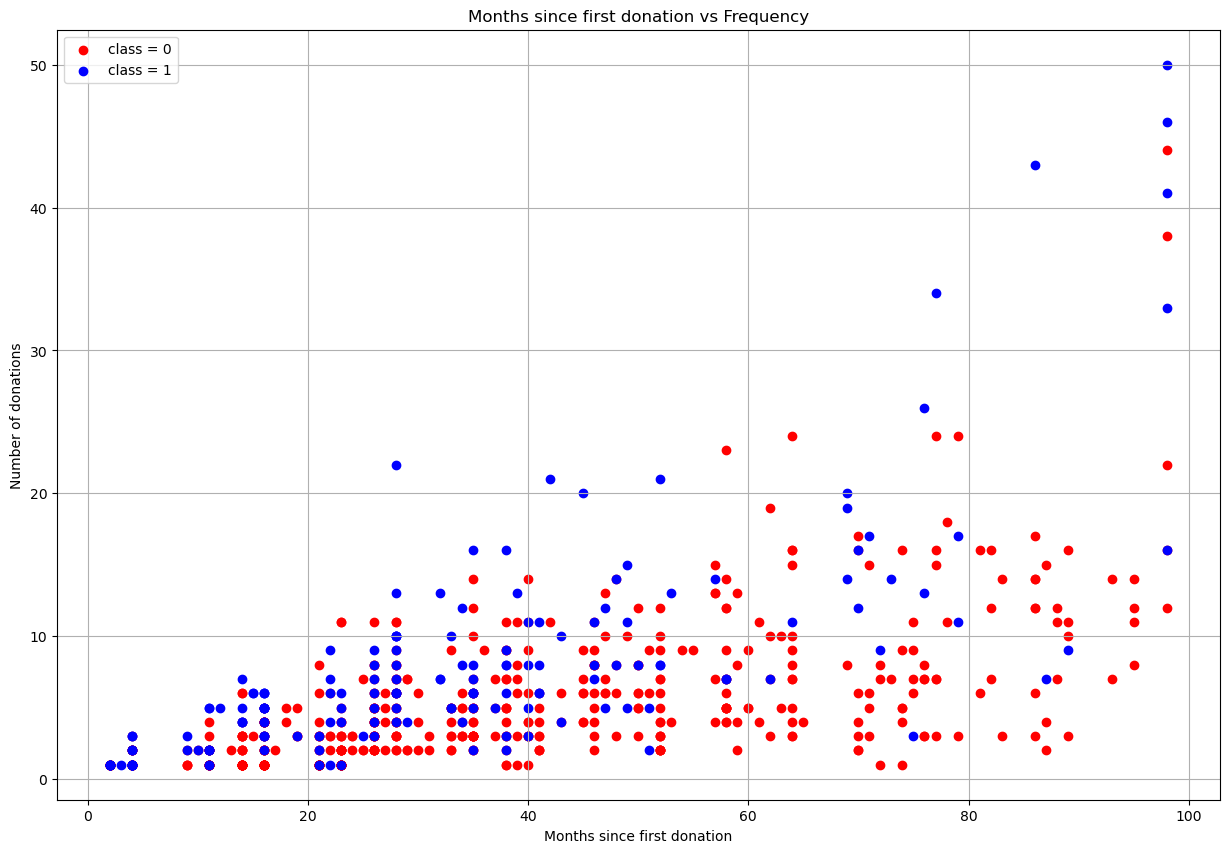

In [277]:
df.describe()
loc_df_class_0 = df.loc[df['class'] == 0]
loc_df_class_1 = df.loc[df['class'] == 1]

plt.figure(figsize=(15, 10))
plt.scatter(loc_df_class_0['months_since_first_donation'], loc_df_class_0['total_number_of_donations'], color='red', label='class = 0')
plt.scatter(loc_df_class_1['months_since_first_donation'], loc_df_class_1['total_number_of_donations'], color='blue', label='class = 1')
plt.xlabel('Months since first donation')
plt.title('Months since first donation vs Frequency')
plt.ylabel('Number of donations')
plt.legend()
plt.grid()

plt.show()

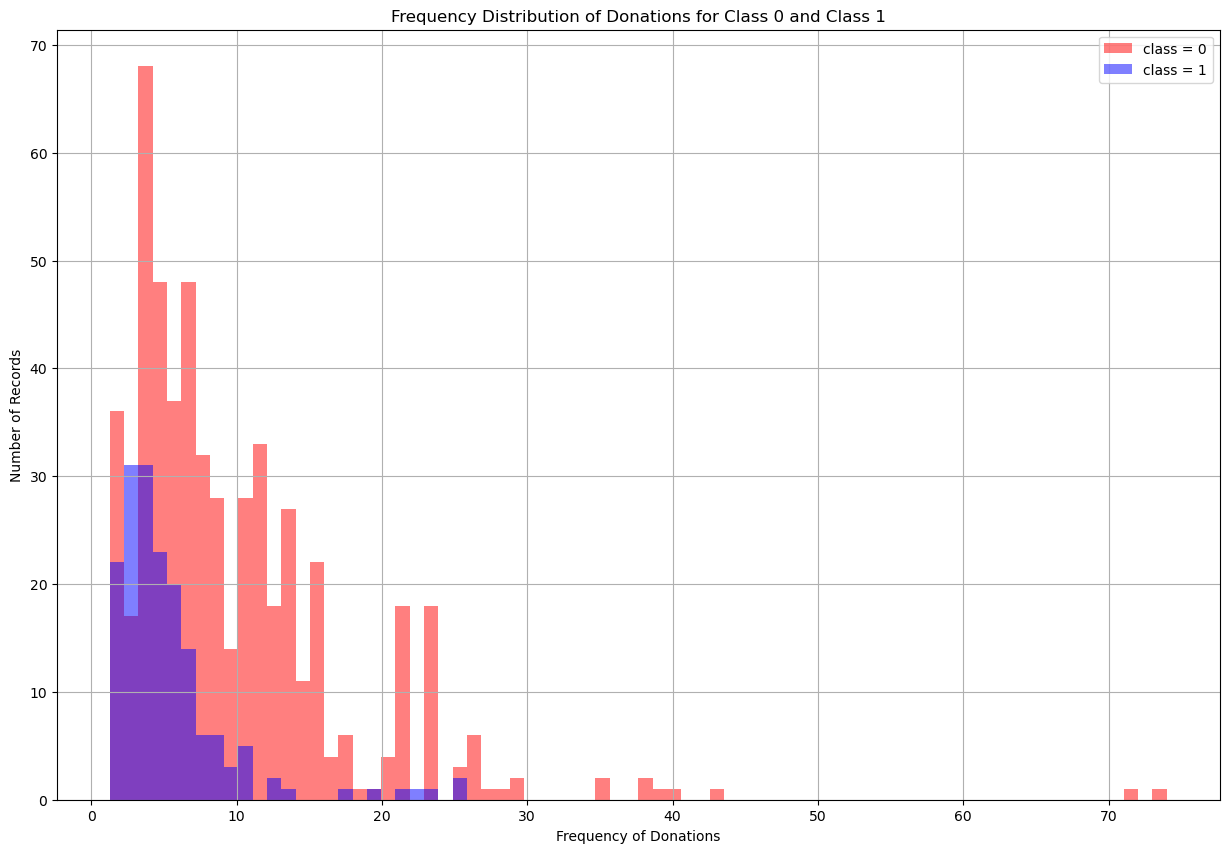

In [278]:
freq_class_0 = loc_df_class_0_with_freq['Average_frequency_donations']
freq_class_1 = loc_df_class_1_with_freq['Average_frequency_donations']

bins = np.linspace(min(freq_class_0.min(), freq_class_1.min()), max(freq_class_0.max(), freq_class_1.max()), 75)

plt.figure(figsize=(15, 10))

# Histogram for class1
hist_class_0, bins_class_0 = np.histogram(freq_class_0, bins=bins)
plt.bar(bins_class_0[:-1], hist_class_0, width=np.diff(bins_class_0), align='edge', color='red', alpha=0.5, label='class = 0')

# histpgram for class 2
hist_class_1, bins_class_1 = np.histogram(freq_class_1, bins=bins)
plt.bar(bins_class_1[:-1], hist_class_1, width=np.diff(bins_class_1), align='edge', color='blue', alpha=0.5, label='class = 1')

plt.xlabel('Frequency of Donations')
plt.ylabel('Number of Records')
plt.title('Frequency Distribution of Donations for Class 0 and Class 1')
plt.legend()
plt.grid()
plt.show()

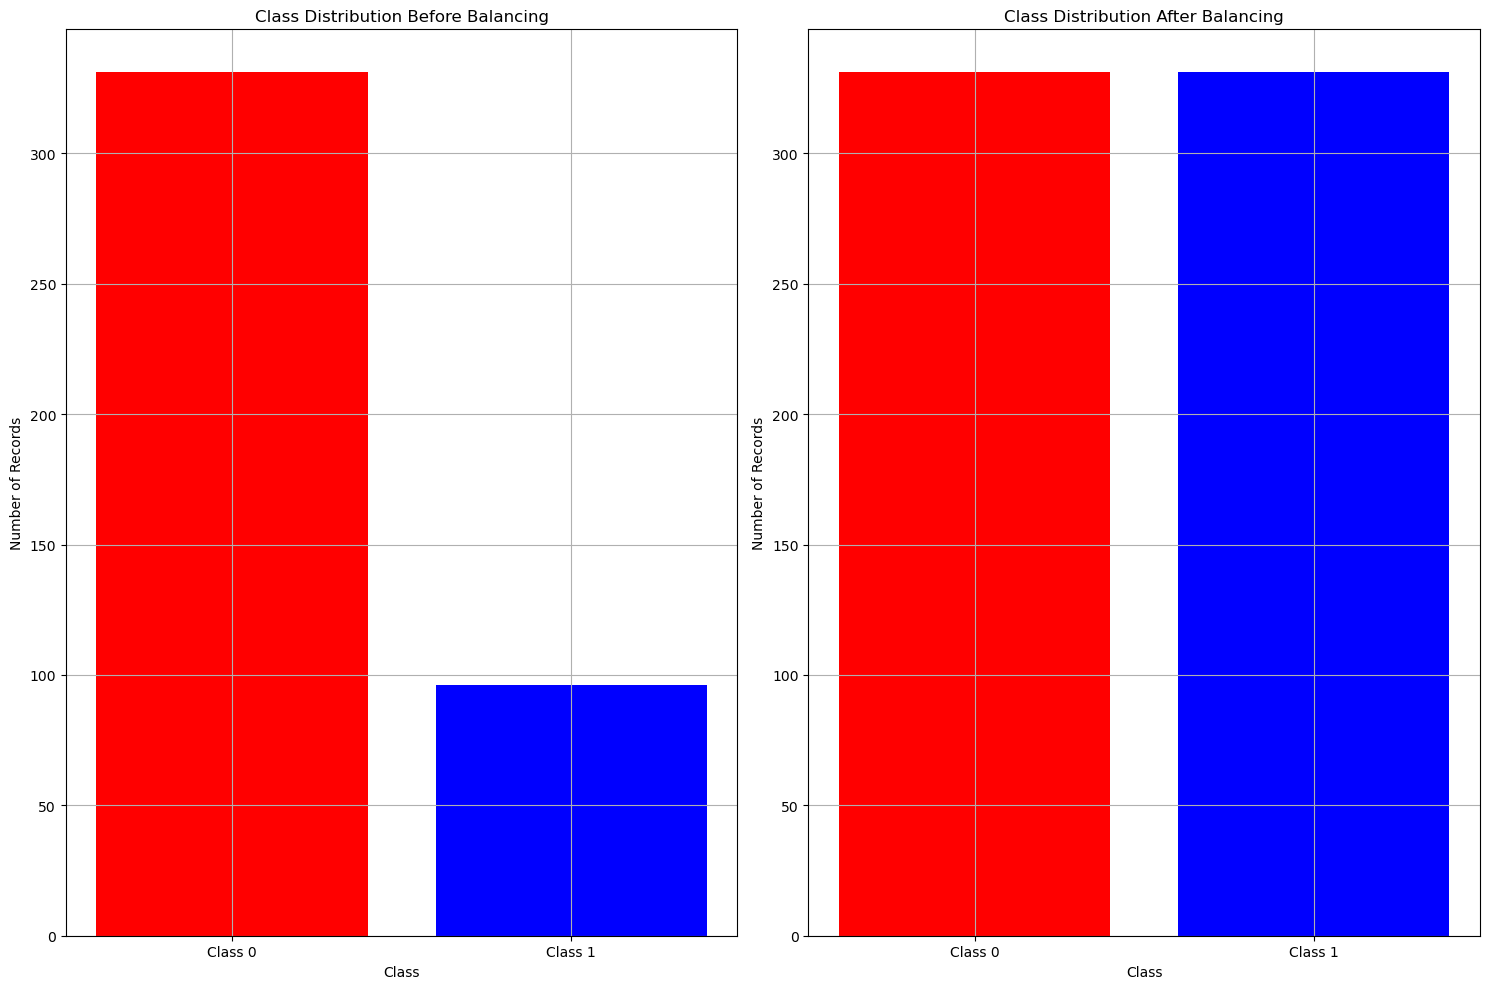

In [279]:
# Splitting the data for training and testing
X = df.drop(columns=['class'])
y = df['class']
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X, y, test_size=0.20, random_state=42)
X_train_40, X_test_40, y_train_40, y_test_40 = train_test_split(X, y, test_size=0.40, random_state=42)

# scaling of the data
scaler = MinMaxScaler()

X_train_scaled_20 = scaler.fit_transform(X_train_20)
X_test_scaled_20 = scaler.transform(X_test_20)

X_train_scaled_40 = scaler.fit_transform(X_train_40)
X_test_scaled_40 = scaler.transform(X_test_40)

# Balance the dataset using SMOTE
sm = SMOTE(random_state=42)
X_train_res_20, y_train_res_20 = sm.fit_resample(X_train_20, y_train_20)

X_train_res_40, y_train_res_40 = sm.fit_resample(X_train_40, y_train_40)

# Train SVM on balanced data
scaler_balanced = StandardScaler()
X_train_scaled_balanced_20 = scaler_balanced.fit_transform(X_train_res_20)
X_test_scaled_balanced_20 = scaler_balanced.transform(X_test_20)

X_train_scaled_balanced_40 = scaler_balanced.fit_transform(X_train_res_40)
X_test_scaled_balanced_40 = scaler_balanced.transform(X_test_40)


# Calculate class counts before and after balancing
class_counts_before = y_train_20.value_counts()
class_counts_after = y_train_res_20.value_counts()

class_counts_before = y_train_40.value_counts()
class_counts_after = y_train_res_40.value_counts()

## Vizualisation of the imbalance
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.bar(['Class 0', 'Class 1'], [class_counts_before[0], class_counts_before[1]], color=['red', 'blue'])
plt.xlabel('Class')
plt.ylabel('Number of Records')
plt.title('Class Distribution Before Balancing')
plt.grid()
# Plot after balancing
plt.subplot(1, 2, 2)
plt.bar(['Class 0', 'Class 1'], [class_counts_after[0], class_counts_after[1]], color=['red', 'blue'])
plt.xlabel('Class')
plt.ylabel('Number of Records')
plt.title('Class Distribution After Balancing')
plt.grid()
plt.tight_layout()
plt.show()

In [280]:
# Define a confusion matrix function
def confusion_matrix(pred, original):
    matrix = np.zeros((2, 2))
    for i in range(len(pred)):
        if int(pred[i]) == 1 and int(original.iloc[i]) == 1: 
            matrix[0, 0] += 1
        elif int(pred[i]) == 1 and int(original.iloc[i]) == 0:
            matrix[0, 1] += 1
        elif int(pred[i]) == 0 and int(original.iloc[i]) == 1:
            matrix[1, 0] += 1
        elif int(pred[i]) == 0 and int(original.iloc[i]) == 0:
            matrix[1, 1] += 1
    return matrix

In [281]:

# Simple euclidean distance function
def euclidean_distances(p1, p2):
    distance = 0.0
    for i in range(len(p1)):
        distance += (p1[i] - p2[i]) ** 2
    return math.sqrt(distance)

def knn_classifier(X_train, y_train, X_test, k):
    pred =[]
    for test in X_test:
        distances=[]
        for i in range(len(X_train)):
            dist = euclidean_distances(test, X_train[i])
            distances.append((dist, y_train[i]))

        distances.sort() # sort based on distance
        neighbors = distances[:k] # get the K nearest neigb
        classes=[]
        for neighbor in neighbors:
            classes.append(neighbor[1])
        predicted_class = max(set(classes), key=classes.count)
        pred.append(predicted_class)
    return pred



In [282]:

# df_KNN = df.copy()
# df_KNN_with_freq = df_with_freq.copy()

# X = df_KNN.drop(columns=['class'])
# y = df_KNN['class']

# df_KNN = scaler.fit_transform(df_KNN)
# X = X.astype(float)

In [283]:

# KNN classifier on the imbalanced dataset with 80/20 split
predicted_labels = knn_classifier(X_train_20.values, y_train_20.values, X_test_20.values, k=3)
confusion_knn_imbalance = confusion_matrix(predicted_labels, y_test_20)
fbeta_score_knn_imbalance = fbeta_score(y_test_20, predicted_labels, beta=0.5)
print('KNN Classifier imbalanced on train split 80/20')
print("Confusion Matrix (Imbalanced KNN):\n", confusion_knn_imbalance)
print("Classification Report (Imbalanced KNN):\n", classification_report(y_test_20, predicted_labels, target_names=['class 0', 'class 1']))
print("Fbeta score (Imbalanced KNN):\n", fbeta_score_knn_imbalance)

# KNN classifier on the balanced dataset 80/20 split
predicted_labels_balanced = knn_classifier(X_train_res_20.values, y_train_res_20.values, X_test_20.values, k=3)
confusion_knn_balanced = confusion_matrix(predicted_labels_balanced, y_test_20)
fbeta_score_knn_balanced = fbeta_score(y_test_20, predicted_labels_balanced, beta=0.5)
print('KNN Classifier balanced on train split 80/20')
print("Confusion Matrix (Balanced KNN):\n", confusion_knn_balanced)
print("Classification Report (Balanced KNN):\n", classification_report(y_test_20, predicted_labels_balanced, target_names=['class 0', 'class 1']))
print("Fbeta score (Balanced KNN):\n", fbeta_score_knn_balanced)



# printing predictions vs actual on samle of 8
random_indices = X_test_20.sample(n=8, random_state=42).index
selected_cases = X_test_20.loc[random_indices]
actual_labels = y_test_20.loc[random_indices]
predicted_labels = knn_classifier(X_train_20.values, y_train_20.values, selected_cases.values, 3)

for i in range(len(predicted_labels)):
    print(f"Predicted: {predicted_labels[i]}, Actual: {actual_labels.iloc[i]}")

KNN Classifier imbalanced on train split 80/20
Confusion Matrix (Imbalanced KNN):
 [[ 8. 19.]
 [28. 88.]]
Classification Report (Imbalanced KNN):
               precision    recall  f1-score   support

     class 0       0.76      0.82      0.79       107
     class 1       0.30      0.22      0.25        36

    accuracy                           0.67       143
   macro avg       0.53      0.52      0.52       143
weighted avg       0.64      0.67      0.65       143

Fbeta score (Imbalanced KNN):
 0.2777777777777778
KNN Classifier balanced on train split 80/20
Confusion Matrix (Balanced KNN):
 [[18. 31.]
 [18. 76.]]
Classification Report (Balanced KNN):
               precision    recall  f1-score   support

     class 0       0.81      0.71      0.76       107
     class 1       0.37      0.50      0.42        36

    accuracy                           0.66       143
   macro avg       0.59      0.61      0.59       143
weighted avg       0.70      0.66      0.67       143

Fbeta sc

In [284]:
# KNN classifier on the imbalanced dataset with 60/40 split
predicted_labels = knn_classifier(X_train_40.values, y_train_40.values, X_test_40.values, k=3)
confusion_knn_imbalance = confusion_matrix(predicted_labels, y_test_40)
fbeta_score_knn_imbalance = fbeta_score(y_test_40, predicted_labels, beta=0.5)
print('KNN Classifier imbalanced on train split 60/40')
print("Confusion Matrix (Imbalanced KNN):\n", confusion_knn_imbalance)
print("Classification Report (Imbalanced KNN for):\n", classification_report(y_test_40, predicted_labels, target_names=['class 0', 'class 1']))
print("Fbeta score (Imbalanced KNN):\n", fbeta_score_knn_imbalance)


# KNN classifier on the balanced dataset 60/40 split
predicted_labels_balanced = knn_classifier(X_train_res_40.values, y_train_res_40.values, X_test_40.values, k=3)
confusion_knn_balanced = confusion_matrix(predicted_labels_balanced, y_test_40)
fbeta_score_knn_balanced = fbeta_score(y_test_40, predicted_labels_balanced, beta=0.5)
print('KNN Classifier balanced on train split 60/40')
print("Confusion Matrix (Balanced KNN):\n", confusion_knn_balanced)
print("Classification Report (Balanced KNN):\n", classification_report(y_test_40, predicted_labels_balanced, target_names=['class 0', 'class 1']))
print("Fbeta score (Balanced KNN):\n", fbeta_score_knn_balanced)

# printing predictions vs actual on samle of 8
random_indices = X_test_40.sample(n=8, random_state=42).index
selected_cases = X_test_40.loc[random_indices]
actual_labels = y_test_40.loc[random_indices]
predicted_labels = knn_classifier(X_train_40.values, y_train_40.values, selected_cases.values, 3)

for i in range(len(predicted_labels)):
    print(f"Predicted: {predicted_labels[i]}, Actual: {actual_labels.iloc[i]}")

KNN Classifier imbalanced on train split 60/40
Confusion Matrix (Imbalanced KNN):
 [[ 15.  40.]
 [ 60. 170.]]
Classification Report (Imbalanced KNN for):
               precision    recall  f1-score   support

     class 0       0.74      0.81      0.77       210
     class 1       0.27      0.20      0.23        75

    accuracy                           0.65       285
   macro avg       0.51      0.50      0.50       285
weighted avg       0.62      0.65      0.63       285

Fbeta score (Imbalanced KNN):
 0.2542372881355932
KNN Classifier balanced on train split 60/40
Confusion Matrix (Balanced KNN):
 [[ 39.  76.]
 [ 36. 134.]]
Classification Report (Balanced KNN):
               precision    recall  f1-score   support

     class 0       0.79      0.64      0.71       210
     class 1       0.34      0.52      0.41        75

    accuracy                           0.61       285
   macro avg       0.56      0.58      0.56       285
weighted avg       0.67      0.61      0.63       2

In [285]:
# Train Naive Bayes on imbalanced data 80/20 split
gnb = GaussianNB()
gnb.fit(X_train_20, y_train_20)
y_pred_imbalanced = gnb.predict(X_test_20)
confusion_naive_imbalance = confusion_matrix(y_pred_imbalanced, y_test_20)
fbeta_score_naive_imbalance = fbeta_score(y_test_20, y_pred_imbalanced, beta=0.5)
print('Naive Bayes Classifier imbalanced on train split 80/20')
print("Confusion Matrix (Imbalanced Naive Bayes):\n", confusion_naive_imbalance)
print("Classification Report (Imbalanced Naive Bayes):\n", classification_report(y_test_20, y_pred_imbalanced, target_names=['class 0', 'class 1']))
print("Fbeta score (Imbalanced Naive Bayes):\n", fbeta_score_naive_imbalance)

# Train Naive Bayes on balanced data 80/20 split
gnb.fit(X_train_res_20, y_train_res_20)
y_pred_balanced = gnb.predict(X_test_20)
confusion_naive_balance = confusion_matrix(y_pred_balanced, y_test_20)
fbeta_score_naive_balanced = fbeta_score(y_test_20, y_pred_balanced, beta=0.5)
print('Naive Bayes Classifier balanced on train split 80/20')
print("Confusion Matrix (Balanced Naive Bayes):\n", confusion_naive_balance)
print("Classification Report (Balanced Naive Bayes):\n", classification_report(y_test_20, y_pred_balanced, target_names=['class 0', 'class 1']))
print("Fbeta score (Balanced Naive Bayes):\n", fbeta_score_naive_balanced)

comparison_classification_report = classification_report(y_test_20, y_pred_imbalanced, target_names=['class 0', 'class 1'])


# printing predictions vs actual on samle of 80/20 split
random_indices = X_test_20.sample(n=8, random_state=42).index
selected_cases = X_test_20.loc[random_indices]
actual_labels = y_test_20.loc[random_indices]
predicted_labels = gnb.predict(selected_cases)

for i in range(len(predicted_labels)):
    print(f"Predicted: {predicted_labels[i]}, Actual: {actual_labels.iloc[i]}")

Naive Bayes Classifier imbalanced on train split 80/20
Confusion Matrix (Imbalanced Naive Bayes):
 [[  2.   5.]
 [ 34. 102.]]
Classification Report (Imbalanced Naive Bayes):
               precision    recall  f1-score   support

     class 0       0.75      0.95      0.84       107
     class 1       0.29      0.06      0.09        36

    accuracy                           0.73       143
   macro avg       0.52      0.50      0.47       143
weighted avg       0.63      0.73      0.65       143

Fbeta score (Imbalanced Naive Bayes):
 0.15625
Naive Bayes Classifier balanced on train split 80/20
Confusion Matrix (Balanced Naive Bayes):
 [[26. 56.]
 [10. 51.]]
Classification Report (Balanced Naive Bayes):
               precision    recall  f1-score   support

     class 0       0.84      0.48      0.61       107
     class 1       0.32      0.72      0.44        36

    accuracy                           0.54       143
   macro avg       0.58      0.60      0.52       143
weighted avg  

In [286]:
# Train Naive Bayes on imbalanced data
gnb = GaussianNB()
gnb.fit(X_train_40, y_train_40)
y_pred_imbalanced = gnb.predict(X_test_40)
confusion_naive_imbalance = confusion_matrix(y_pred_imbalanced, y_test_40)
fbeta_score_naive_imbalance = fbeta_score(y_test_40, y_pred_imbalanced, beta=0.5)
print('Naive Bayes Classifier imbalanced on train split 60/40')
print("Confusion Matrix (Imbalanced Naive Bayes):\n", confusion_naive_imbalance)
print("Classification Report (Imbalanced Naive Bayes):\n", classification_report(y_test_40, y_pred_imbalanced, target_names=['class 0', 'class 1']))
print("Fbeta score (Imbalanced Naive Bayes):\n", fbeta_score_naive_imbalance)

# Train Naive Bayes on balanced data
gnb.fit(X_train_res_40, y_train_res_40)
y_pred_balanced = gnb.predict(X_test_40)
confusion_naive_balance = confusion_matrix(y_pred_balanced, y_test_40)
fbeta_score_naive_balanced = fbeta_score(y_test_40, y_pred_balanced, beta=0.5)
print('Naive Bayes Classifier balanced on train split 60/40')
print("Confusion Matrix (Balanced Naive Bayes):\n", confusion_naive_balance)
print("Classification Report (Balanced Naive Bayes):\n", classification_report(y_test_40, y_pred_balanced, target_names=['class 0', 'class 1']))
print("Fbeta score (Balanced Naive Bayes):\n", fbeta_score_naive_balanced)

comparison_classification_report = classification_report(y_test_40, y_pred_imbalanced, target_names=['class 0', 'class 1'])


# printing predictions vs actual on samle of 8 
random_indices = X_test_40.sample(n=8, random_state=42).index
selected_cases = X_test_40.loc[random_indices]
actual_labels = y_test_40.loc[random_indices]
predicted_labels = gnb.predict(selected_cases)

for i in range(len(predicted_labels)):
    print(f"Predicted: {predicted_labels[i]}, Actual: {actual_labels.iloc[i]}")

Naive Bayes Classifier imbalanced on train split 60/40
Confusion Matrix (Imbalanced Naive Bayes):
 [[  8.  17.]
 [ 67. 193.]]
Classification Report (Imbalanced Naive Bayes):
               precision    recall  f1-score   support

     class 0       0.74      0.92      0.82       210
     class 1       0.32      0.11      0.16        75

    accuracy                           0.71       285
   macro avg       0.53      0.51      0.49       285
weighted avg       0.63      0.71      0.65       285

Fbeta score (Imbalanced Naive Bayes):
 0.22857142857142856
Naive Bayes Classifier balanced on train split 60/40
Confusion Matrix (Balanced Naive Bayes):
 [[ 37.  59.]
 [ 38. 151.]]
Classification Report (Balanced Naive Bayes):
               precision    recall  f1-score   support

     class 0       0.80      0.72      0.76       210
     class 1       0.39      0.49      0.43        75

    accuracy                           0.66       285
   macro avg       0.59      0.61      0.59       28

In [287]:
# Train SVM on imbalanced data 80/20 split
svc_clf_imbalanced = svm.SVC()
svc_clf_imbalanced.fit(X_train_scaled_20, y_train_20)
y_pred_svc_imbalanced = svc_clf_imbalanced.predict(X_test_scaled_20)
confusion_svc_imbalance = confusion_matrix(y_pred_svc_imbalanced, y_test_20)
fbeta_score_svc_imbalance = fbeta_score(y_test_20, y_pred_svc_imbalanced, beta=0.5)
print('SVM imbalanced on train split 80/20')
print("Confusion Matrix (Imbalanced SVM):\n", confusion_svc_imbalance)
print("Classification Report (Imbalanced SVM):\n", classification_report(y_test_20, y_pred_svc_imbalanced, target_names=['class 0', 'class 1']))
print("Fbeta score (Imbalanced SVM):\n", fbeta_score_svc_imbalance)

# Train SVM on balanced data 80/20 split
svc_clf_balanced = svm.SVC()
svc_clf_balanced.fit(X_train_scaled_balanced_20, y_train_res_20)
y_pred_svc_balanced = svc_clf_balanced.predict(X_test_scaled_balanced_20)
confusion_svc_balance = confusion_matrix(y_pred_svc_balanced, y_test_20)
fbeta_score_svc_balanced = fbeta_score(y_test_20, y_pred_svc_balanced, beta=0.5)
print('SVM balanced on train split 80/20')
print("Confusion Matrix (Balanced SVM):\n", confusion_svc_balance)
print("Classification Report (Balanced SVM):\n", classification_report(y_test_20, y_pred_svc_balanced, target_names=['class 0', 'class 1']))
print("Fbeta score (Balanced SVM):\n", fbeta_score_svc_balanced)


# printing predictions vs actual on samle of 8 80/20 split
random_indices = X_test_20.sample(n=8, random_state=42).index
selected_cases = X_test_20.loc[random_indices]
actual_labels = y_test_20.loc[random_indices]
predicted_labels = svc_clf_imbalanced.predict(selected_cases)
for i in range(len(predicted_labels)):
    print(f"Predicted: {predicted_labels[i]}, Actual: {actual_labels.iloc[i]}")

SVM imbalanced on train split 80/20
Confusion Matrix (Imbalanced SVM):
 [[  3.   1.]
 [ 33. 106.]]
Classification Report (Imbalanced SVM):
               precision    recall  f1-score   support

     class 0       0.76      0.99      0.86       107
     class 1       0.75      0.08      0.15        36

    accuracy                           0.76       143
   macro avg       0.76      0.54      0.51       143
weighted avg       0.76      0.76      0.68       143

Fbeta score (Imbalanced SVM):
 0.28846153846153844
SVM balanced on train split 80/20
Confusion Matrix (Balanced SVM):
 [[20. 34.]
 [16. 73.]]
Classification Report (Balanced SVM):
               precision    recall  f1-score   support

     class 0       0.82      0.68      0.74       107
     class 1       0.37      0.56      0.44        36

    accuracy                           0.65       143
   macro avg       0.60      0.62      0.59       143
weighted avg       0.71      0.65      0.67       143

Fbeta score (Balanced SVM

/Users/noahuddin/miniconda3/envs/Dat01/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [288]:
# Train SVM on imbalanced data 60/40 split
svc_clf_imbalanced = svm.SVC()
svc_clf_imbalanced.fit(X_train_scaled_40, y_train_40)
y_pred_svc_imbalanced = svc_clf_imbalanced.predict(X_test_scaled_40)
confusion_svc_imbalance = confusion_matrix(y_pred_svc_imbalanced, y_test_40)
fbeta_score_svc_imbalance = fbeta_score(y_test_40, y_pred_svc_imbalanced, beta=0.5)
print('SVM imbalanced on train split 60/40')
print("Confusion Matrix (Imbalanced SVM):\n", confusion_svc_imbalance)
print("Classification Report (Imbalanced SVM):\n", classification_report(y_test_40, y_pred_svc_imbalanced, target_names=['class 0', 'class 1']))
print("Fbeta score (Imbalanced SVM):\n", fbeta_score_svc_imbalance)

# Train SVM on balanced data 60/40 split
svc_clf_balanced = svm.SVC()
svc_clf_balanced.fit(X_train_scaled_balanced_40, y_train_res_40)
y_pred_svc_balanced = svc_clf_balanced.predict(X_test_scaled_balanced_40)
confusion_svc_balance = confusion_matrix(y_pred_svc_balanced, y_test_40)
fbeta_score_svc_balanced = fbeta_score(y_test_40, y_pred_svc_balanced, beta=0.5)
print('SVM balanced on train split 80/20')
print("Confusion Matrix (Balanced SVM):\n", confusion_svc_balance)
print("Classification Report (Balanced SVM):\n", classification_report(y_test_40, y_pred_svc_balanced, target_names=['class 0', 'class 1']))
print("Fbeta score (Balanced SVM):\n", fbeta_score_svc_balanced)


# printing predictions vs actual on samle of 60/40 split
random_indices = X_test_40.sample(n=8, random_state=42).index
selected_cases = X_test_40.loc[random_indices]
actual_labels = y_test_40.loc[random_indices]
predicted_labels = svc_clf_imbalanced.predict(selected_cases)
for i in range(len(predicted_labels)):
    print(f"Predicted: {predicted_labels[i]}, Actual: {actual_labels.iloc[i]}")

SVM imbalanced on train split 60/40
Confusion Matrix (Imbalanced SVM):
 [[  2.   4.]
 [ 73. 206.]]
Classification Report (Imbalanced SVM):
               precision    recall  f1-score   support

     class 0       0.74      0.98      0.84       210
     class 1       0.33      0.03      0.05        75

    accuracy                           0.73       285
   macro avg       0.54      0.50      0.45       285
weighted avg       0.63      0.73      0.63       285

Fbeta score (Imbalanced SVM):
 0.10101010101010101
SVM balanced on train split 80/20
Confusion Matrix (Balanced SVM):
 [[ 46.  60.]
 [ 29. 150.]]
Classification Report (Balanced SVM):
               precision    recall  f1-score   support

     class 0       0.84      0.71      0.77       210
     class 1       0.43      0.61      0.51        75

    accuracy                           0.69       285
   macro avg       0.64      0.66      0.64       285
weighted avg       0.73      0.69      0.70       285

Fbeta score (Balanced

/Users/noahuddin/miniconda3/envs/Dat01/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [289]:
# Train MLP on imbalanced data 80/20 split
mlp_clf_imbalanced = MLPClassifier(max_iter=1000, random_state=42)
mlp_clf_imbalanced.fit(X_train_scaled_20, y_train_20)
y_pred_mlp_imbalanced = mlp_clf_imbalanced.predict(X_test_scaled_20)
confusion_mlp_imbalance = confusion_matrix(y_pred_mlp_imbalanced, y_test_20)
fbeta_score_mlp_imbalance = fbeta_score(y_test_20, y_pred_mlp_imbalanced, beta=0.5)
print('MLP Classifier on imbalanced with train split 80/20')
print("Confusion Matrix (Imbalanced MLP):\n", confusion_mlp_imbalance)
print("Classification Report (Imbalanced MLP):\n", classification_report(y_test_20, y_pred_mlp_imbalanced, target_names=['class 0', 'class 1']))
print("Fbeta score (Imbalanced MLP):\n", fbeta_score_mlp_imbalance)

# Train MLP on balanced data 80/20 split
mlp_clf_balanced = MLPClassifier(max_iter=1000, random_state=42)
mlp_clf_balanced.fit(X_train_scaled_balanced_20, y_train_res_20)
y_pred_mlp_balanced = mlp_clf_balanced.predict(X_test_scaled_balanced_20)
confusion_mlp_balance = confusion_matrix(y_pred_mlp_balanced, y_test_20)
fbeta_score_mlp_balanced = fbeta_score(y_test_20, y_pred_mlp_balanced, beta=0.5)
print('MLP Classifier on balanced with train split 80/20')
print("Confusion Matrix (Balanced MLP):\n", confusion_mlp_balance)
print("Classification Report (Balanced MLP):\n", classification_report(y_test_20, y_pred_mlp_balanced, target_names=['class 0', 'class 1']))
print("Fbeta score (Balanced MLP):\n", fbeta_score_mlp_balanced)


# printing predictions vs actual on samle of 8 80/20 split
random_indices = X_test_20.sample(n=8, random_state=42).index
selected_cases = X_test_20.loc[random_indices]
actual_labels = y_test_20.loc[random_indices]
predicted_labels = mlp_clf_imbalanced.predict(selected_cases)
for i in range(len(predicted_labels)):
    print(f"Predicted: {predicted_labels[i]}, Actual: {actual_labels.iloc[i]}")

MLP Classifier on imbalanced with train split 80/20
Confusion Matrix (Imbalanced MLP):
 [[  1.   1.]
 [ 35. 106.]]
Classification Report (Imbalanced MLP):
               precision    recall  f1-score   support

     class 0       0.75      0.99      0.85       107
     class 1       0.50      0.03      0.05        36

    accuracy                           0.75       143
   macro avg       0.63      0.51      0.45       143
weighted avg       0.69      0.75      0.65       143

Fbeta score (Imbalanced MLP):
 0.11363636363636363
MLP Classifier on balanced with train split 80/20
Confusion Matrix (Balanced MLP):
 [[20. 32.]
 [16. 75.]]
Classification Report (Balanced MLP):
               precision    recall  f1-score   support

     class 0       0.82      0.70      0.76       107
     class 1       0.38      0.56      0.45        36

    accuracy                           0.66       143
   macro avg       0.60      0.63      0.61       143
weighted avg       0.71      0.66      0.68     

/Users/noahuddin/miniconda3/envs/Dat01/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [290]:
# Train MLP on imbalanced data
mlp_clf_imbalanced = MLPClassifier(max_iter=1000, random_state=42)
mlp_clf_imbalanced.fit(X_train_scaled_40, y_train_40)
y_pred_mlp_imbalanced = mlp_clf_imbalanced.predict(X_test_scaled_40)
confusion_mlp_imbalance = confusion_matrix(y_pred_mlp_imbalanced, y_test_40)
fbeta_score_mlp_imbalance = fbeta_score(y_test_40, y_pred_mlp_imbalanced, beta=0.5)
print('MLP Classifier on imbalanced with train split 60/40')
print("Confusion Matrix (Imbalanced MLP):\n", confusion_mlp_imbalance)
print("Classification Report (Imbalanced MLP):\n", classification_report(y_test_40, y_pred_mlp_imbalanced, target_names=['class 0', 'class 1']))
print("Fbeta score (Imbalanced MLP):\n", fbeta_score_mlp_imbalance)

# Train MLP on balanced data
mlp_clf_balanced = MLPClassifier(max_iter=1000, random_state=42)
mlp_clf_balanced.fit(X_train_scaled_balanced_40, y_train_res_40)
y_pred_mlp_balanced = mlp_clf_balanced.predict(X_test_scaled_balanced_40)
confusion_mlp_balance = confusion_matrix(y_pred_mlp_balanced, y_test_40)
fbeta_score_mlp_balanced = fbeta_score(y_test_40, y_pred_mlp_balanced, beta=0.5)
print('MLP Classifier on balanced with train split 60/40')
print("Confusion Matrix (Balanced MLP):\n", confusion_mlp_balance)
print("Classification Report (Balanced MLP):\n", classification_report(y_test_40, y_pred_mlp_balanced, target_names=['class 0', 'class 1']))
print("Fbeta score (Balanced MLP):\n", fbeta_score_mlp_balanced)


# printing predictions vs actual on samle of 8
random_indices = X_test_40.sample(n=8, random_state=42).index
selected_cases = X_test_40.loc[random_indices]
actual_labels = y_test_40.loc[random_indices]
predicted_labels = mlp_clf_imbalanced.predict(selected_cases)
for i in range(len(predicted_labels)):
    print(f"Predicted: {predicted_labels[i]}, Actual: {actual_labels.iloc[i]}")

MLP Classifier on imbalanced with train split 60/40
Confusion Matrix (Imbalanced MLP):
 [[  7.   8.]
 [ 68. 202.]]
Classification Report (Imbalanced MLP):
               precision    recall  f1-score   support

     class 0       0.75      0.96      0.84       210
     class 1       0.47      0.09      0.16        75

    accuracy                           0.73       285
   macro avg       0.61      0.53      0.50       285
weighted avg       0.67      0.73      0.66       285

Fbeta score (Imbalanced MLP):
 0.25925925925925924
MLP Classifier on balanced with train split 60/40
Confusion Matrix (Balanced MLP):
 [[ 47.  57.]
 [ 28. 153.]]
Classification Report (Balanced MLP):
               precision    recall  f1-score   support

     class 0       0.85      0.73      0.78       210
     class 1       0.45      0.63      0.53        75

    accuracy                           0.70       285
   macro avg       0.65      0.68      0.65       285
weighted avg       0.74      0.70      0.71 

/Users/noahuddin/miniconda3/envs/Dat01/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Fold 0:
0.4
Fold 1:
0.37735849056603776
Fold 2:
0.1724137931034483
Fold 3:
0.5172413793103449
Fold 4:
0.46296296296296297
Fold 5:
0.5263157894736842
Fold 6:
0.4411764705882353
Fold 7:
0.0
Fold 8:
0.5952380952380952
Fold 9:
0.29411764705882354


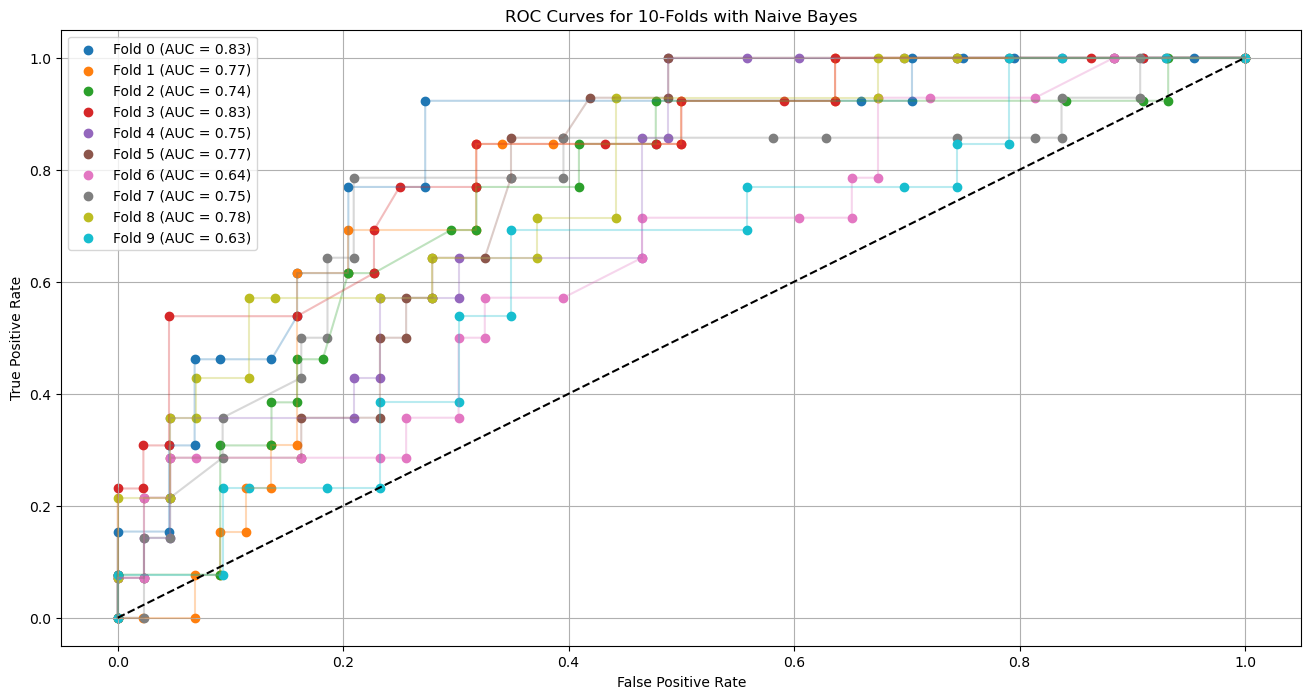

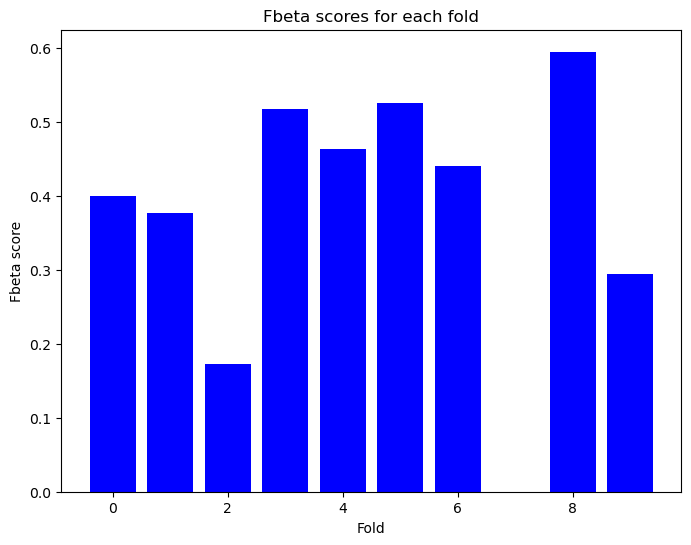

In [296]:
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X, y, test_size=0.20, random_state=42)

skf = StratifiedKFold(n_splits=10)

plt.figure(figsize=(16, 8))
confusion_scores_fold = []
classification_reports_fold = []
fbeta_scores_fold = []
roc_auc_scores_fold = []
gnb = GaussianNB()

for i, (train_index, val_index) in enumerate(skf.split(X_train_20, y_train_20)):
    X_train_fold, X_val_fold = X_train_20.iloc[train_index], X_train_20.iloc[val_index]
    y_train_fold, y_val_fold = y_train_20.iloc[train_index], y_train_20.iloc[val_index]

    gnb.fit(X_train_fold, y_train_fold)
    y_pred_imbalance = gnb.predict(X_val_fold)
    y_pred_proba = gnb.predict_proba(X_val_fold)[:, 1]

    # confusion_imbalance = confusion_matrix(y_val_fold, y_pred_imbalance)
    roc_auc_fold = roc_auc_score(y_val_fold, y_pred_proba)
    classification_report_fold = classification_report(y_val_fold, y_pred_imbalance, target_names=['class 0', 'class 1'])
    fbeta_score_fold = fbeta_score(y_val_fold, y_pred_imbalance, beta=0.5)
    # confusion_scores_fold.append(confusion_imbalance)
    classification_reports_fold.append(classification_report_fold)
    fbeta_scores_fold.append(fbeta_score_fold)
    roc_auc_scores_fold.append(roc_auc_fold)

    fpr, tpr, _ = roc_curve(y_val_fold, y_pred_proba)
    plt.scatter(fpr, tpr, label=f'Fold {i} (AUC = {roc_auc_fold:.2f})')
    plt.plot(fpr, tpr, alpha=0.3)
    print(f"Fold {i}:")
    # print(confusion_imbalance)
    print(fbeta_score_fold)

# ROC plot
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves for 10-Folds with Naive Bayes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# FBETA- score plot
plt.figure(figsize=(8, 6))
plt.bar(range(len(fbeta_scores_fold)), fbeta_scores_fold, color='blue')
plt.title('Fbeta scores for each fold')
plt.xlabel('Fold')
plt.ylabel('Fbeta score')
plt.show()

In [ ]:
fbeta_comparison_fold = [fbeta_score_naive_imbalance, fbeta_scores_fold[8]]
labels = ["not using cross-validation", "using cross-validation"]

plt.figure(figsize=(10,5))
plt.bar(labels, fbeta_comparison_fold, color='blue')

plt.title('No cross validation vs. Cross validation')
plt.xlabel('Naive Bayes')
plt.ylabel('Fbeta score')
plt.show()

print("Not using cross-validation: ")
print("Confusion Matrix (Imbalanced Naive Bayes):\n", confusion_naive_imbalance)
print("Classification Report (Imbalanced Naive Bayes):\n", comparison_classification_report)
print("Fbeta score (Imbalanced Naive Bayes):\n", fbeta_score_naive_imbalance)

print("Using cross-validation: ")
print("Confusion Matrix (Imbalanced Naive Bayes Cross-validated):\n", confusion_scores_fold[8])
print("Classification Report (Imbalanced Naive Bayes Cross-validated):\n", classification_reports_fold[8])
print("Fbeta score (Imbalanced Naive Bayes Cross-validated):\n", fbeta_scores_fold[8])

Fold 0:
0.6060606060606061
Fold 1:
0.38461538461538464
Fold 2:
0.4411764705882353
Fold 3:
0.47619047619047616
Fold 4:
0.3333333333333333
Fold 5:
0.5
Fold 6:
0.0
Fold 7:
0.45454545454545453
Fold 8:
0.7142857142857143
Fold 9:
0.0


/Users/noahuddin/miniconda3/envs/Dat01/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/noahuddin/miniconda3/envs/Dat01/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/noahuddin/miniconda3/envs/Dat01/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

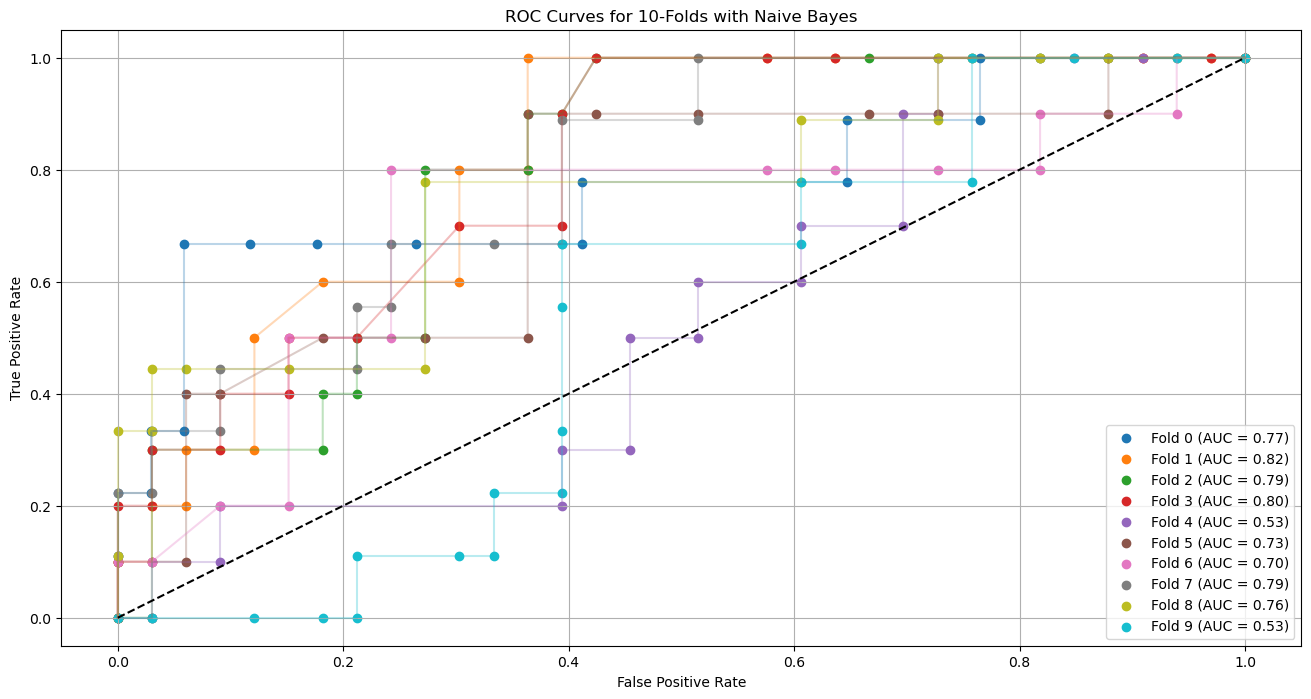

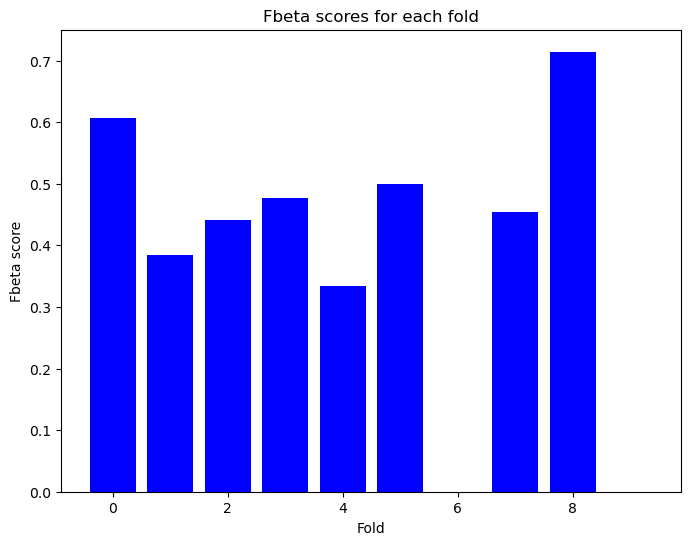

In [295]:
# For the 60/40 split
skf = StratifiedKFold(n_splits=10)

plt.figure(figsize=(16, 8))
confusion_scores_fold = []
classification_reports_fold = []
fbeta_scores_fold = []
roc_auc_scores_fold = []
gnb = GaussianNB()

for i, (train_index, val_index) in enumerate(skf.split(X_train_40, y_train_40)):
    X_train_fold, X_val_fold = X_train_40.iloc[train_index], X_train_40.iloc[val_index]
    y_train_fold, y_val_fold = y_train_40.iloc[train_index], y_train_40.iloc[val_index]

    gnb.fit(X_train_fold, y_train_fold)
    y_pred_imbalance = gnb.predict(X_val_fold)
    y_pred_proba = gnb.predict_proba(X_val_fold)[:, 1]

    # confusion_imbalance = confusion_matrix(y_val_fold, y_pred_imbalance)
    roc_auc_fold = roc_auc_score(y_val_fold, y_pred_proba)
    classification_report_fold = classification_report(y_val_fold, y_pred_imbalance, target_names=['class 0', 'class 1'])
    fbeta_score_fold = fbeta_score(y_val_fold, y_pred_imbalance, beta=0.5)
    # confusion_scores_fold.append(confusion_imbalance)
    classification_reports_fold.append(classification_report_fold)
    fbeta_scores_fold.append(fbeta_score_fold)
    roc_auc_scores_fold.append(roc_auc_fold)

    fpr, tpr, _ = roc_curve(y_val_fold, y_pred_proba)
    plt.scatter(fpr, tpr, label=f'Fold {i} (AUC = {roc_auc_fold:.2f})')
    plt.plot(fpr, tpr, alpha=0.3)
    print(f"Fold {i}:")
    # print(confusion_imbalance)
    print(fbeta_score_fold)

# ROC plot
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves for 10-Folds with Naive Bayes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# FBETA- score plot
plt.figure(figsize=(8, 6))
plt.bar(range(len(fbeta_scores_fold)), fbeta_scores_fold, color='blue')
plt.title('Fbeta scores for each fold')
plt.xlabel('Fold')
plt.ylabel('Fbeta score')
plt.show()

In [ ]:
fbeta_comparison_fold = [fbeta_score_naive_imbalance, fbeta_scores_fold[8]]
labels = ["not using cross-validation", "using cross-validation"]

plt.figure(figsize=(10,5))
plt.bar(labels, fbeta_comparison_fold, color='blue')

plt.title('No cross validation vs. Cross validation')
plt.xlabel('Naive Bayes')
plt.ylabel('Fbeta score')
plt.show()

print("Not using cross-validation: ")
print("Confusion Matrix (Imbalanced Naive Bayes):\n", confusion_naive_imbalance)
print("Classification Report (Imbalanced Naive Bayes):\n", comparison_classification_report)
print("Fbeta score (Imbalanced Naive Bayes):\n", fbeta_score_naive_imbalance)

print("Using cross-validation: ")
print("Confusion Matrix (Imbalanced Naive Bayes Cross-validated):\n", confusion_scores_fold[8])
print("Classification Report (Imbalanced Naive Bayes Cross-validated):\n", classification_reports_fold[8])
print("Fbeta score (Imbalanced Naive Bayes Cross-validated):\n", fbeta_scores_fold[8])